<a href="https://colab.research.google.com/github/MuhammadRhakan/alternative/blob/main/2_Alternate_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
!pip install leidenalg igraph gower

In [181]:
import nltk
import kagglehub
import sys
import random
import leidenalg
import gower

import pandas as pd
import numpy as np
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from kagglehub.datasets import KaggleDatasetAdapter
from datetime import datetime
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from scipy.sparse import csr_matrix, vstack, hstack
from networkx.algorithms import community

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "andrewmvd/udemy-courses", "udemy_courses.csv")

<ipython-input-3-98990312>:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "andrewmvd/udemy-courses", "udemy_courses.csv")


In [ ]:
course.head(4)

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance


In [42]:
#get numerics
def numeric_attributes(data):
  numerics = [num for num in data.select_dtypes(include = 'number').drop(columns='course_id').columns.values]
  print(f"\033[1mNumeric Attributes:\033[0m\n{numerics}\n")

  return numerics


#initial cleaning
def basic_cleaning(data):
  print(f'\033[1mBasic Cleaning: \033[0m')
  print(f'📐 Initial Data Shape: {data.shape}')

  duplicated = data.duplicated().sum()
  data = data.drop_duplicates().reset_index(drop=True)
  print(f"✅ Done! {duplicated} duplicates have been removed.")

  nulls = data[(data['num_lectures'] == 0) | (data['content_duration'] == 0)].index
  data = data.replace({
      'num_lectures': {0: data['num_lectures'].mean()},
      'content_duration': {0: data['content_duration'].median()}})

  print(f"✅ Done! {len(nulls)} missing values have been handled.")

  print('-'*28)
  print(f'📐 Data Shape  : {data.shape}')

  return data


#get years
def get_years(data, feature):
  copy = data.copy()
  copy[feature] = pd.to_datetime(copy[feature], format="%Y-%m-%dT%H:%M:%SZ", utc=True)
  copy['years'] = copy[feature].dt.year

  return copy


#deal with outliers
def outliers_handling(data, features, method, par):
  data_cleaned = data.copy()

  if method == 'iqr':
    mask = pd.Series(False, index=data.index)
    for col in features:
      Q1 = data[col].quantile(1-par)
      Q3 = data[col].quantile(par)
      IQR = Q3 - Q1
      lower = Q1 - 1.5 * IQR
      upper = Q3 + 1.5 * IQR
      mask |= (data[col] < lower) | (data[col] > upper)
    data_cleaned = data_cleaned[~mask]

  elif method == 'clip':
    for col in features:
      upper = data[col].quantile(par)
      data_cleaned[col] = data_cleaned[col].clip(upper=upper)

  elif method == 'trim':
    for col in features:
      upper = data[col].quantile(par)
      data_cleaned = data_cleaned[data_cleaned[col] < upper]

  else:
    raise ValueError("Method must be 'iqr', 'clip', or 'trim'")

  return data_cleaned


#finalize
def get_clean_data(data, features, method, par):
  cleaned = outliers_handling(data, features, method, par)
  transformed = cleaned.copy()

  if method == 'iqr' or method == 'clip':
    transformed[features] = np.sqrt(transformed[features])
  elif method == 'trim':
    _price = [feat for feat in features if feat != 'price']
    transformed[_price] = np.log1p(transformed[_price])

  return cleaned, transformed

In [43]:
numerics = numeric_attributes(course)
course_basic_clean = basic_cleaning(course)
course_basic_clean = get_years(course_basic_clean, 'published_timestamp')

clip, clip_scaled = get_clean_data(course_basic_clean, features=numerics, method='clip', par=0.9)
iqr, iqr_scaled = get_clean_data(course_basic_clean, features=numerics, method='iqr', par=0.75)
trim, trim_scaled = get_clean_data(course_basic_clean, features=numerics, method='trim', par=0.8)

Numeric Attributes:
['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

Basic Cleaning: 
📐 Initial Data Shape: (3678, 12)
✅ Done! 6 duplicates have been removed.
✅ Done! 1 missing values have been handled.
----------------------------
📐 Data Shape  : (3672, 12)


In [90]:
def semantic_preprocessing(data, feature):
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()

  semantic = data[feature].str.lower()
  semantic = semantic.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words]))

  vectorizer = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.9, ngram_range=(1, 3), dtype=np.float32)
  tfidf_matrix = vectorizer.fit_transform(semantic)
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

  cos_similarity = cosine_similarity(tfidf_matrix)

  print(f'TF-IDF Matrix             :  {tfidf_matrix.shape[0]} rows x {tfidf_matrix.shape[1]} words')
  print(f'TF-IDF Similarity Matrix  :  {cos_similarity.shape[0]} items x {cos_similarity.shape[1]} items\n')

  print(f"Size of TF-IDF Matrix :     {sys.getsizeof(tfidf_matrix)/1000000} MB")
  print(f"Size of TF-IDF Table  :     {sys.getsizeof(tfidf_df)/1000000} MB")
  print(f"Size of Similarity Matrix:  {sys.getsizeof(cos_similarity)/1000000} MB")

  return tfidf_matrix.toarray(), tfidf_df, cos_similarity

In [150]:
def numerical_preprocessing(data, feature, metric):
  normalized_matrix = normalize(data[feature])
  normalized_df = pd.DataFrame(data=normalized_matrix, columns=data[feature].columns)

  if metric == 'euclidean':
    cos_similarity = euclidean_distances(normalized_matrix)

  elif metric == 'cosine':
    cos_similarity = cosine_similarity(normalized_matrix)

  print(f"Size of Numeric Matrix :   {sys.getsizeof(normalized_matrix)/1000000} MB")
  print(f"Size of Numeric Table  :   {sys.getsizeof(normalized_df)/1000000} MB")
  print(f"Size of Similarity Matrix: {sys.getsizeof(cos_similarity)/1000000} MB")

  return normalized_matrix, normalized_df, cos_similarity

In [75]:
def nominal_preprocessing(data, features):
  nominal = data[features].copy()

  for col in features:
    if np.issubdtype(nominal[col].dtype, np.number):
      nominal[col] = nominal[col].astype(str)

  nominal_df = pd.get_dummies(nominal, prefix=nominal.columns)
  nominal_matrix = nominal_df.values.astype(int)

  grouped_subsets = {}
  for col in nominal_df.columns:
    prefix = col.split('_')[0]
    grouped_subsets.setdefault(prefix, []).append(col)

  DS_results = {}
  for prefix, cols in grouped_subsets.items():
    binary_matrix = nominal_df[cols].values.astype(int)

    ni = binary_matrix.sum(axis=1)
    nij = binary_matrix @ binary_matrix.T

    denom = ni[:, None] + ni[None, :]
    denom[denom == 0] = 1e-12  # avoid zero division

    DS = (2 * nij) / denom
    DS[np.isnan(DS)] = 0.0

    dice_similarity = DS.astype(np.float16)

    print(f"\n--- {prefix.upper()} ---")
    print(f"Group Columns: {cols}")
    print(f"Binary Matrix: {binary_matrix.shape}")
    print(f"DS Matrix: {dice_similarity.shape}")
    print(f"Size of Binary Matrix: {sys.getsizeof(binary_matrix)/1e6:.2f} MB")
    print(f"Size of DS Matrix: {sys.getsizeof(dice_similarity)/1e6:.2f} MB")

    DS_results[prefix] = dice_similarity

  return nominal_matrix, nominal_df, grouped_subsets, DS_results

In [91]:
semantic_matrix, semantic_df, semantic_similarity = semantic_preprocessing(clip, 'course_title')

TF-IDF Matrix             :  3672 rows x 1000 words
TF-IDF Similarity Matrix  :  3672 items x 3672 items

Size of TF-IDF Matrix :     5.6e-05 MB
Size of TF-IDF Table  :     14.688164 MB
Size of Similarity Matrix:  53.934464 MB


In [151]:
numeric_matrix, numeric_df, numeric_similarity = numerical_preprocessing(clip_scaled, numerics, metric='euclidean')

Size of Numeric Matrix :   0.000128 MB
Size of Numeric Table  :   0.147044 MB
Size of Similarity Matrix: 107.8688 MB


In [76]:
nominal_matrix, nominal_df, nominal_subsets, nominal_similarity_groups = nominal_preprocessing(clip, features=['subject', 'level', 'years'])


--- SUBJECT ---
Group Columns: ['subject_Business Finance', 'subject_Graphic Design', 'subject_Musical Instruments', 'subject_Web Development']
Binary Matrix: (3672, 4)
DS Matrix: (3672, 3672)
Size of Binary Matrix: 0.12 MB
Size of DS Matrix: 26.97 MB

--- LEVEL ---
Group Columns: ['level_All Levels', 'level_Beginner Level', 'level_Expert Level', 'level_Intermediate Level']
Binary Matrix: (3672, 4)
DS Matrix: (3672, 3672)
Size of Binary Matrix: 0.12 MB
Size of DS Matrix: 26.97 MB

--- YEARS ---
Group Columns: ['years_2011', 'years_2012', 'years_2013', 'years_2014', 'years_2015', 'years_2016', 'years_2017']
Binary Matrix: (3672, 7)
DS Matrix: (3672, 3672)
Size of Binary Matrix: 0.21 MB
Size of DS Matrix: 26.97 MB


In [189]:
def multiattributes(*data, form):
  initial = data[0]
  for i in data[1:]:
    if form =='df':
      iter = pd.concat([initial, i], axis=1)
    elif form == 'matrix':
      iter = np.concatenate((initial, i), axis=1)
    else:
      raise ValueError("form must be 'df' or 'matrix'")

    combined = initial = iter

  return combined

def combined_data(form):
  if form == 'df':
    return multiattributes(semantic_df, numeric_df, nominal_df, form=form)
  elif form == 'matrix':
    return multiattributes(semantic_matrix, numeric_matrix, nominal_matrix, form=form)
  else:
    raise ValueError("form must be 'df' or 'matrix'")

'''
Brief Summary
Data Frame columns in order:
1. Semantics: 1000 vectors (features)
2. Numerics: 5 features
3. Nominal: 15 encoded features(4 categories + 4 levels + 7 years)

Total Dices: 5
'''

def single_multiattributes_pipeline(data):
  semantic_block = data[:, slice(0, 1000)]
  numeric_block = data[:, slice(1000, 1005)]
  nominal_block = data[:, slice(1005, 1020)]

  #1. semantic -> cosine similarity
  semantic_similarity = cosine_similarity(semantic_block)

  #2. numeric -> euclidean distance
  numeric_distance = euclidean_distances(numeric_block)
  numeric_similarity = 1 / (1 + numeric_distance)

  #3. nominal -> dice similarity
  dice_similarity = []
  start = 0
  nominal_group_sizes = [4, 4, 7] #4 categories, 4 levels, 7 years
  for cols in nominal_group_sizes:
    end = start + cols
    nominal_col = nominal_block[:, start:end]

    ni = nominal_col.sum(axis=1)
    nij = nominal_col @ nominal_col.T

    denom = ni[:, None] + ni[None, :]
    denom[denom == 0] = 1e-12

    dice = (2 * nij) / denom
    dice_similarity.append(dice)
    start = end

  multiattribute_similarity = (semantic_similarity + numeric_similarity + sum(dice_similarity)) / 5

  return multiattribute_similarity

In [190]:
all_matrices = combined_data(form='matrix')
all_dfs = combined_data(form='df')
single_multiattributes_pipeline(all_matrices)

array([[1.        , 0.7786244 , 0.37130636, ..., 0.34173508, 0.35790267,
        0.17877991],
       [0.7786244 , 1.        , 0.38255979, ..., 0.35830669, 0.35919678,
        0.18207275],
       [0.37130636, 0.38255979, 1.        , ..., 0.1476968 , 0.35359384,
        0.18571582],
       ...,
       [0.34173508, 0.35830669, 0.1476968 , ..., 1.        , 0.56174744,
        0.40646237],
       [0.35790267, 0.35919678, 0.35359384, ..., 0.56174744, 1.        ,
        0.37671536],
       [0.17877991, 0.18207275, 0.18571582, ..., 0.40646237, 0.37671536,
        1.        ]])

In [110]:
def multiattribute_similarity(*similarities, method=None, weights=None):
  print(f'Similarity Combination Approach: {method}')

  #mean approach
  if method == 'average':
    similarity_stack = np.stack(similarities, axis=2)
    combined_similarity = np.mean(similarity_stack, axis=2)

  #feature weighing approach
  elif method == 'weighted':
    if len(weights) != len(similarities):
      raise ValueError(f"Number of weights ({len(weights)}) must match number of similarities ({len(similarities)})")
    combined_similarity = sum(w * sim for w, sim in zip(weights, similarities))

  else:
    raise ValueError("method must be 'average' or 'weighted'")

  print(f'Numeric Similarity Matrix : {combined_similarity.shape[0]} items x {combined_similarity.shape[1]} items')
  print(f"Size of Similarity Matrix : {sys.getsizeof(combined_similarity)/1000000} MB")

  return combined_similarity

In [175]:
mas = multiattribute_similarity(
    semantic_similarity,
    numeric_similarity,
    *list(nominal_similarity_groups.values()),
    method='average',
    # weights=[0.4, 0.25, 0.35]
    )

Similarity Combination Approach: average
Numeric Similarity Matrix : 3672 items x 3672 items
Size of Similarity Matrix : 107.8688 MB


In [ ]:
def gower_mixed_similarity(data):
  gower_similarity = gower.gower_matrix(data)
  print(f'Gower Similarity Matrix : {gower_similarity.shape[0]} items x {gower_similarity.shape[1]} items')
  print(f"Size of Similarity Matrix : {sys.getsizeof(gower_similarity)/1000000} MB")

  return gower_similarity

gower_similarity = gower_mixed_similarity(all_dfs)

In [187]:
def network_graph_model(data, threshold):
  G = nx.Graph()

  nodes = len(data)
  G.add_nodes_from(range(nodes))

  for i in range(nodes):
    for j in range(i+1, nodes):
      weight = data[i,j]
      if weight >= threshold and i != j:
        G.add_edge(i, j, weight=weight)

  print(f"Number of nodes: {G.number_of_nodes()}")
  print(f"Number of edges: {G.number_of_edges()}")

  return G

In [188]:
def network_performance_check(data):
  thresholds = np.arange(0.5, 1.0, 0.05)
  results = []

  for t in thresholds:
    G = network_graph_model(data, threshold=t)
    density = nx.density(G)
    clustering = nx.average_clustering(G)
    components = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len)
    largest_fraction = len(largest_cc) / G.number_of_nodes()
    results.append((t, density, clustering, components, largest_fraction))

  df_results = pd.DataFrame(results, columns=['Threshold', 'Density', 'Clustering', 'Components', 'Largest Fraction'])
  return df_results

network_performance_check(mas)

Number of nodes: 3672
Number of edges: 1430941
Number of nodes: 3672
Number of edges: 924162
Number of nodes: 3672
Number of edges: 249082
Number of nodes: 3672
Number of edges: 201233
Number of nodes: 3672
Number of edges: 187573
Number of nodes: 3672
Number of edges: 124610
Number of nodes: 3672
Number of edges: 14629
Number of nodes: 3672
Number of edges: 3019
Number of nodes: 3672
Number of edges: 983
Number of nodes: 3672
Number of edges: 242


,Threshold,Density,Clustering,Components,Largest Fraction
0,0.50,0.212307,0.553721,1,1.000000
1,0.55,0.137117,0.507219,1,1.000000
2,0.60,0.036956,0.670828,3,0.999455
3,0.65,0.029857,0.893355,4,0.999183
4,0.70,0.027830,0.942096,8,0.997004
5,0.75,0.018488,0.791963,50,0.474129
6,0.80,0.002170,0.380491,638,0.066993
7,0.85,0.000448,0.204870,2027,0.044935
8,0.90,0.000146,0.075224,3109,0.005991
9,0.95,0.000036,0.022667,3501,0.003813


In [192]:
G = network_graph_model(mas, threshold = 0.75)

Number of nodes: 3672
Number of edges: 124610


Central node: 3064, degree: 242


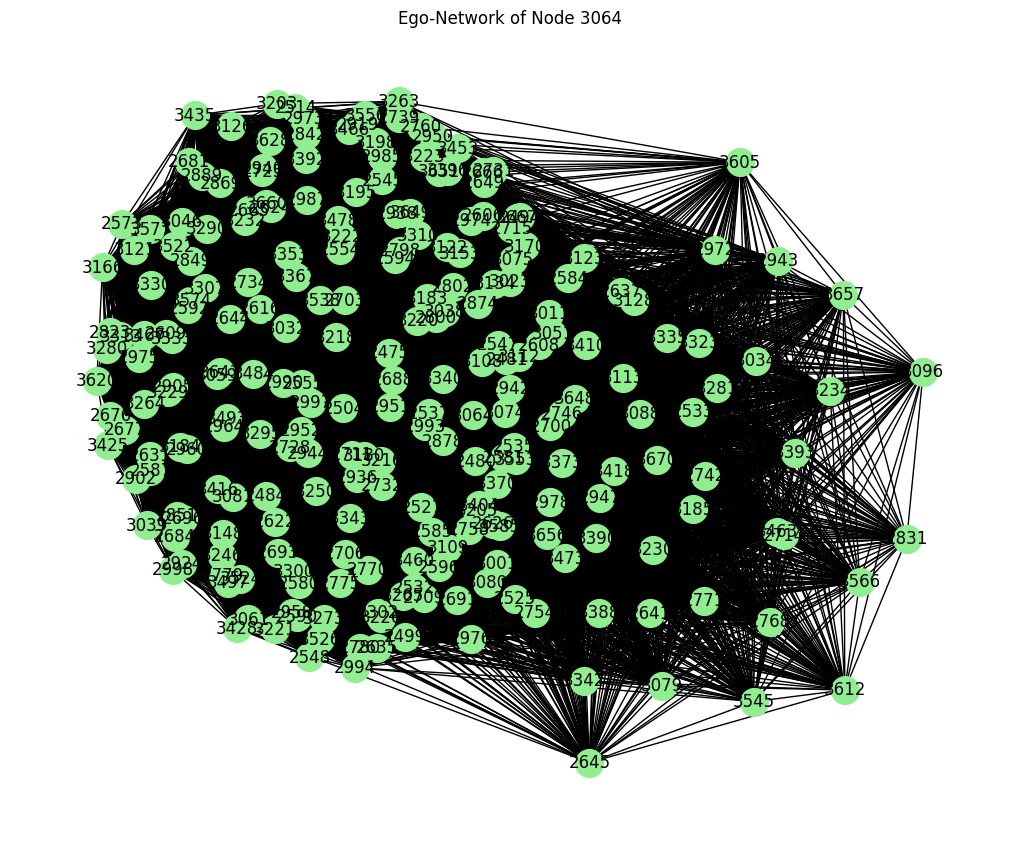

In [193]:
def network_graph_visualization(G):
  degrees = dict(G.degree())
  central_node = max(degrees, key=degrees.get)
  print(f"Central node: {central_node}, degree: {degrees[central_node]}")

  ego = nx.ego_graph(G, central_node, radius=1)

  plt.figure(figsize=(10, 8))
  pos = nx.spring_layout(ego, seed=42)
  nx.draw(ego, pos, with_labels=True, node_color='lightgreen', node_size=400)
  plt.title(f"Ego-Network of Node {central_node}")
  plt.show()

network_graph_visualization(G)

In [194]:
def plotly_network(G, method, size=50, node=None, seed=42):
  # Pick subgraph
  if method == "ego":
      if node is None:
          degrees = dict(G.degree())
          node = max(degrees, key=degrees.get)
      subG = nx.ego_graph(G, node, radius=1)  # radius can be parameterized if you want
      title = f"Ego-Network of Node {node}"
  elif method == "connected":
      components = list(nx.connected_components(G))
      largest = max(components, key=len)
      if size >= len(largest):
          sample_nodes = largest
      else:
          sample_nodes = random.sample(list(largest), size)
      subG = G.subgraph(sample_nodes)
      title = f"Connected Subgraph of {len(subG.nodes())} Nodes"
  else:
      raise ValueError("method must be 'ego' or 'connected'")

  # Get layout
  pos = nx.spring_layout(subG, seed=seed)

  # Edges
  edge_x, edge_y = [], []
  for u, v in subG.edges():
      x0, y0 = pos[u]
      x1, y1 = pos[v]
      edge_x += [x0, x1, None]
      edge_y += [y0, y1, None]
  edge_trace = go.Scatter(
      x=edge_x, y=edge_y,
      line=dict(width=1, color='#888'),
      hoverinfo='none',
      mode='lines'
  )

  # Nodes
  node_x, node_y, node_text = [], [], []
  for n in subG.nodes():
      x, y = pos[n]
      node_x.append(x)
      node_y.append(y)
      node_text.append(f'Node: {n}<br>Degree: {subG.degree[n]}')

  node_trace = go.Scatter(
      x=node_x, y=node_y,
      mode='markers+text',
      textposition='top center',
      hoverinfo='text',
      marker=dict(
          showscale=True,
          colorscale='YlGnBu',
          color=[subG.degree[n] for n in subG.nodes()],
          size=12,
          colorbar=dict(
              thickness=15,
              title='Node Degree',
              xanchor='left',
              titleside='right'
          )
      ),
      text=[str(n) for n in subG.nodes()],
  )

  # Final plot
  fig = go.Figure(data=[edge_trace, node_trace],
                  layout=go.Layout(
                      title=title,
                      titlefont_size=16,
                      showlegend=False,
                      hovermode='closest',
                      margin=dict(b=20, l=5, r=5, t=40),
                      annotations=[dict(showarrow=False,
                                        xref="paper", yref="paper",
                                        x=0.005, y=-0.002)],
                      xaxis=dict(showgrid=False, zeroline=False),
                      yaxis=dict(showgrid=False, zeroline=False)
                  )
                  )

  fig.show()

In [195]:
plotly_network(G, method="ego")

In [197]:
plotly_network(G, method="ego", node=2000)

### Keep in Tank

In [ ]:
def semantic(data, features):
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()

  for col in features:
    semantic = data[col].str.lower()
    semantic = semantic.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words]))

  vectorizer = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.9, ngram_range=(1, 3), dtype=np.float32)
  tfidf_matrix = vectorizer.fit_transform(semantic)
  # tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
  cos_similarity = cosine_similarity(tfidf_matrix)

  print(f"Size of TFIDF Matrix  :     {sys.getsizeof(tfidf_matrix)/1000000} MB")
  print(f"Size of Similarity Table  :     {sys.getsizeof(cos_similarity)/1000000} MB")

  return tfidf_matrix, cos_similarity

semantic_matrix, semantic_similarity = semantic(clip, features=['title', 'headline', 'topic'])

In [ ]:
def numeric(data, features):
  normalized_matrix = normalize(data[features])
  # normalized_df = pd.DataFrame(data=normalized_matrix, columns=data[features].columns)
  cos_similarity = cosine_similarity(normalized_matrix)

  print(f"Size of Numeric Matrix :   {sys.getsizeof(normalized_matrix)/1000000} MB")
  print(f"Size of Similarity Matrix: {sys.getsizeof(cos_similarity)/1000000} MB")

  return normalized_matrix, cos_similarity

numbers_matrix, numbers_similarity = numeric(clip_scaled, numerics)

In [ ]:
def nominal_preprocessing(data, features):
  nominal = data[features].copy()

  for col in features:
    if np.issubdtype(nominal[col].dtype, np.number):
      nominal[col] = nominal[col].astype(str)

  multiattribute_df = pd.get_dummies(nominal, prefix=nominal.columns)

  grouped_subsets = {}
  for col in multiattribute_df.columns:
    prefix = col.split('_')[0]
    grouped_subsets.setdefault(prefix, []).append(col)

  DS_results = {}
  for prefix, cols in grouped_subsets.items():
    binary_matrix = multiattribute_df[cols].values.astype(int)

    ni = binary_matrix.sum(axis=1)
    nij = binary_matrix @ binary_matrix.T

    denom = ni[:, None] + ni[None, :]
    denom[denom == 0] = 1e-12  # avoid zero division

    DS = (2 * nij) / denom
    DS[np.isnan(DS)] = 0.0

    dice_similarity = DS.astype(np.float16)

    print(f"\n--- {prefix.upper()} ---")
    print(f"Group Columns: {cols}")
    print(f"Binary Matrix: {binary_matrix.shape}")
    print(f"DS Matrix: {dice_similarity.shape}")
    print(f"Size of Binary Matrix: {sys.getsizeof(binary_matrix)/1e6:.2f} MB")
    print(f"Size of DS Matrix: {sys.getsizeof(dice_similarity)/1e6:.2f} MB")

    DS_results[prefix] = dice_similarity

  return multiattribute_df, grouped_subsets, DS_results

nominal_preprocessing(clip, features=['subject', 'level', 'years'])